# Solutions to MP2 exercises

In [1]:
import veloxchem as vlx
import numpy as np
from matplotlib import pyplot as plt

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [2]:
# Molecule and basis
h2o_xyz = """3
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        1.100000000000
"""

mol = vlx.Molecule.from_xyz_string(h2o_xyz)

basis = vlx.MolecularBasis.read(mol, "cc-pvdz")

In [3]:
# Run the SCF
scfdrv = vlx.ScfRestrictedDriver()
scf_dict = {'conv_thresh': 1e-8}
scfdrv.update_settings(scf_dict)
scfdrv.compute(mol, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [4]:
# Number of orbitals, orbital energies, MO coefficients, ERIs in spatial MO basis (physicists' notation)
N_MO = scfdrv.scf_tensors['C_alpha'].shape[1]
N_O = mol.number_of_electrons() // 2
N_V = N_MO - N_O
epsilon = scfdrv.scf_tensors["E"]
# epsilon_a - epsilon_i
epsilon_ov =  epsilon[N_O:] - epsilon[:N_O].reshape(-1, 1)
C = scfdrv.scf_tensors["C"]
C_occ = C[:, :N_O]
C_vir = C[:, N_O:]

moeridrv = vlx.MOIntegralsDriver()
eri_oovv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
eri_ooov = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOOV")
eri_ovvv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OVVV")


### Calculate the MP2 amplitudes

The MP2 $t$-amplitudes are defined as:
\begin{align}
t_{ijab} = \frac{\langle ij || ab \rangle}{\epsilon_a + \epsilon_b - \epsilon_i - \epsilon_j} = \frac{\langle ij | ab \rangle - \langle ij | ba \rangle}{\epsilon_a + \epsilon_b - \epsilon_i - \epsilon_j}
\end{align}

In the following, we need to consider different spin blocks:
- For the $\alpha\alpha\alpha\alpha$ block, both integrals survive
- For the $\alpha\beta\alpha\beta$ block, only the first ("Coulomb") integral survives
- For the $\alpha\beta\beta\alpha$ block, only the second ("exchange") integral survives

For a closed-shell system, the blocks with $\alpha$ and $\beta$ exchanged are identical and do not have to be calculated separately.

- Implement the three different spin blocks of the $t$ amplitudes

In [5]:
def get_t_amplitudes(molecule, basis, scfdrv):
    #t_aaaa, t_abab, t_abba
    #t_bbbb, t_baba, t_baab
     
    # orbital energies and oovv integrals (spatial MO basis, physicists' notation)
    moeridrv = vlx.MOIntegralsDriver()
    oovv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
     
    # extract the occupied subset of the orbital energies
    e_occ = scfdrv.scf_tensors["E"][:N_O]
    # extract the virtual subset of the orbital energies
    e_vir = scfdrv.scf_tensors["E"][N_O:]
    e_ab = e_vir + e_vir.reshape(-1, 1) # epsilon_a + epsilon_b (as 2D matrix)
          
    # Different spin blocks (a=alpha, b=beta)
    t2_aaaa = np.zeros((N_O, N_O, N_V, N_V))
    t2_abab = np.zeros((N_O, N_O, N_V, N_V))
    t2_abba = np.zeros((N_O, N_O, N_V, N_V))
    for i in range(N_O):
        for j in range(N_O):
            t2_aaaa[i,j] = (oovv[i, j] - eri_oovv[i, j].T) / (e_ab - e_occ[i] - e_occ[j])
            t2_abab[i,j] = (oovv[i, j]) / (e_ab - e_occ[i] - e_occ[j])
            t2_abba[j,i] = (- eri_oovv[j, i].T) / (e_ab - e_occ[i] - e_occ[j])
            
    t2_mp2 = {'aaaa': t2_aaaa, 'abab': t2_abab, 'abba': t2_abba}

    return t2_mp2
        

### Calculate the MP2 energy correction the straightforward way

- Implement the MP2 energy correction using the following equation in spatial orbitals:

  \begin{equation}
    E_0^{(2)} = - \sum_{ijab} \frac{\langle ij | ab \rangle \langle ij | ab \rangle}{\epsilon_a + \epsilon_b - \epsilon_i - \epsilon_j}
    - \sum_{ijab} \frac{\langle ij | ab \rangle [ \langle ij | ab \rangle - \langle ij | ba \rangle]}{\epsilon_a + \epsilon_b - \epsilon_i - \epsilon_j}
  \end{equation}
  
- The first term corresponds to the _opposite-spin_, the second one to the _same-spin_ contribution

In [6]:
array1 = np.array([[1,2],[3,4]])
print(array1*array1)

[[ 1  4]
 [ 9 16]]


In [7]:
def get_mp2_correction(molecule, basis, scfdrv):
    e_mp2_ss = 0.0
    e_mp2_os = 0.0

    # oovv integrals (spatial MO basis, physicists' notation)
    moeridrv = vlx.MOIntegralsDriver()
    oovv = moeridrv.compute_in_mem(molecule, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")
  
    # extract the occupied subset of the orbital energies
    e_occ = scfdrv.scf_tensors["E"][:N_O]
    # extract the virtual subset of the orbital energies
    e_vir = scfdrv.scf_tensors["E"][N_O:]
    e_ab = e_vir + e_vir.reshape(-1, 1) # epsilon_a + epsilon_b (as 2D matrix)
    
    for i in range(N_O):
        for j in range(N_O):
            e_mp2_os -= np.sum((oovv[i, j] * oovv[i, j]) / (e_ab - e_occ[i] - e_occ[j]))
            e_mp2_ss -= np.sum((oovv[i, j] * (oovv[i, j] - oovv[i, j].T)) / (e_ab - e_occ[i] - e_occ[j]))
    

    return e_mp2_ss, e_mp2_os

In [8]:
e_mp2_ss, e_mp2_os = get_mp2_correction(mol, basis, scfdrv)

In [9]:
print(f"Opposite-spin MP2 energy: {e_mp2_os:20.12f}")
print(f"Same-spin MP2 energy:     {e_mp2_ss:20.12f}")
print(f"MP2 energy:               {e_mp2_os + e_mp2_ss:20.12f}")

Opposite-spin MP2 energy:      -0.156069692863
Same-spin MP2 energy:          -0.052034742400
MP2 energy:                    -0.208104435264


### Calculate the MP2 energy correction using the $t$ amplitudes

The MP2 energy correction can also be calculated in spin orbitals as:
\begin{equation}
E_0^{(2)} = -\frac14\sum_{ijab}t_{ijab}\langle ij || ab \rangle = -\frac14\sum_{ijab} t_{ijab}(\langle ij | ab \rangle - \langle ij | ba \rangle)
\end{equation}

- Use your function to get the $t$ amplitudes and use them to calculate the MP2 energy correction
- Remember that you use spatial orbitals, so take care of the different spin blocks

In [10]:
t2 = get_t_amplitudes(mol, basis, scfdrv)
moeridrv = vlx.MOIntegralsDriver()
eri_oovv = moeridrv.compute_in_mem(mol, basis, mol_orbs=scfdrv.mol_orbs, mints_type="OOVV")

In [12]:
e_mp2 = -0.5*( np.einsum('ijab,ijab->', t2['aaaa'], eri_oovv)
          -np.einsum('ijab,ijba->', t2['aaaa'], eri_oovv)
          +np.einsum('ijab,ijab->', t2['abab'], eri_oovv)
          -np.einsum('ijab,ijba->', t2['abba'], eri_oovv) )

- Compare your results to the one from Veloxchem

In [16]:
mp2driver = vlx.mp2driver.Mp2Driver()
mp2driver.compute(mol, basis, scfdrv.mol_orbs)
e_mp2_vlx = mp2driver.e_mp2
#dir(mp2driver)
print("Difference between Vlx and own implementation of MP2 energy correction:\n", abs(e_mp2 - e_mp2_vlx))

                                                                                                                          
                                                     MP2 Driver Setup                                                     
                                                                                                                          
                               Number of Fock Matrices      : 15                                                          
                               Size of Fock Matrices Batch  : 100                                                         
                               Number of Subcommunicators   : 1                                                           
                               ERI Screening Scheme         : Cauchy Schwarz + Density                                    
                               ERI Screening Threshold      : 1.0e-12                                                     
                

## O$-$H Dissociation Potential Energy Curve

- We want to look at the dissociation of one hydrogen atom in the water molecule
- MP2 represents a significant improvement over the HF energy around the equilibrium bond length
- At longer bond lengths, however, some occupied and virtual orbitals become closer in energy to each other
- This makes the orbital-energy denominator of the MP2 correction smaller, and hence $E_0^{(2)}$ larger and larger (in magnitude)
- The correlation energy will thus be overestimated at some point and the dissociation curve will become non-physical

- Take the following molecule template and calculate the MP2 energy for a series of different bond lengths
- Plot the potential energy curve for RHF and MP2

In [17]:
mol_template = """                                                                                                              
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        OHdist
"""

In [19]:
# list of bond distances
distlist = [0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.1,1.3,1.5,1.7,2,2.5,3,3.4,4.1,4.5]

# empty list for HF and MP2 energies
E_hf = []
E_mp2 = []

# SCF driver
scfdrv_pec = vlx.ScfRestrictedDriver()
#scfdrv.ostream.state = False # To disable the printout
for oh in distlist:
    print("Calculating the energies for... ", oh)
    
    # Create new molecule
    mol_str = mol_template.replace("OHdist", str(oh))
    molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
    basis = vlx.MolecularBasis.read(molecule,"cc-pvdz")
    
    # Compute SCF energy
    scfdrv_pec.compute(molecule, basis)
    E_hf.append(scfdrv_pec.get_scf_energy())
    
    # Compute MP2 energy
    e_mp2_ss, e_mp2_os = get_mp2_correction(molecule, basis, scfdrv_pec)
    E_mp2.append(scfdrv_pec.get_scf_energy() + e_mp2_ss + e_mp2_os)

Calculating the energies for...  0.7
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                               

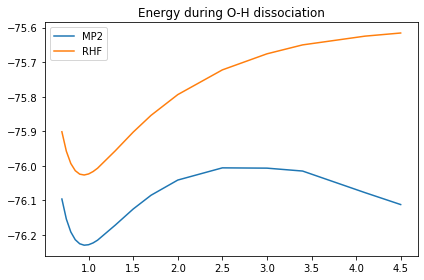

In [21]:
# Plot the results
plt.figure(figsize=(6,4))
plt.title('Energy during O-H dissociation')
x = np.array(distlist)
y = np.array(E_mp2)
z = np.array(E_hf)
plt.plot(x,y, label='MP2')
plt.plot(x,z, label='RHF')
plt.legend()
plt.tight_layout(); plt.show()

- You can compare these curves to the [FCI result](fig:fci-dissociation-curve)

## Dipole moment

One often wants to characterize molecular systems beyond pure energetics.
As an example of another basic property, we look at the electric dipole moment $\boldsymbol{\mu}$, which is an important factor for long-range interaction between different molecules.
The dipole moment $\boldsymbol{\mu}$ is an example of a [first-order property](sec:first-order-prop),
which can be calculated as a derivative of the energy with respect to an external electric field $\boldsymbol{\mathcal{F}}$.
As such, it can be calculated either [numerically](sec:numerical-gradients) or [analytically](sec:analytical-gradients).
In the latter case, the calculation of the electronic contribution to $\boldsymbol{\mu}$ is given by the contraction of the one-particle density matrix $\boldsymbol{\gamma}$ with the dipole integrals ($\mu_{\kappa \lambda}$), either in AO or MO basis. In order to avoid having to transform all property integrals to MO basis, one usually transforms the density matrix to AO.
In the following, we want to look at the dipole moment calculated with different approximation schemes.

\begin{equation}
  \boldsymbol{\mu} = \sum_{\kappa \lambda} \gamma_{\kappa \lambda} \mu_{\lambda \kappa}
\end{equation}

In [14]:
#molecule = vlx.Molecule.from_xyz_string(h2o_xyz)

#basis = vlx.MolecularBasis.read(molecule, "cc-pvdz")

#scfdrv = vlx.ScfRestrictedDriver()
#scfdrv.compute(molecule, basis)

### HF dipole moment

In order to obtain the dipole moment at the HF level, we only have to get the total SCF density and provide it to the `FirstOrderProperties` driver, which takes care of the rest (contraction with the dipole integrals and adding the nuclear contribution).

In [23]:
scf_density = 2 * scfdrv.scf_tensors['D_alpha'] # factor 2 for alpha+beta density
prop = vlx.firstorderprop.FirstOrderProperties()
prop.compute(mol, basis, scf_density)
hf_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(mol, 'HF dipole moment')

                                                                                                                          
                                                     HF dipole moment                                                     
                                                    ------------------                                                    
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :         0.627759 a.u.         1.595604 Debye                                     
                                   Z   :         0.498104 a.u.         1.266055 Debye                                     
                                 Total :         0.801367 a.u.         2.036872 Debye                                     
                

### Unrelaxed MP2 dipole moment

At the MP2 level, additional contributions to all blocks (occ-occ, vir-vir, and occ-vir) of the one-particle density matrix
need to be taken into account.
The occ-vir block of the MP2 density matrix is related to orbital relaxation due to the perturbation
and has to be calculated iteratively (for more details, see [here](sec:mp2-gradients)).
The occ-occ and vir-vir blocks of the second-order correction to the ground-state one-particle density matrix, on the other hand, can directly be calculated from the $t$ amplitudes as
\begin{align}
  \gamma_{ij}^{(2)} &= -\frac12 \sum_{kab} t_{ikab} t_{jkab} \\
  \gamma_{ab}^{(2)} &= \frac12 \sum_{ijc} t_{ijac} t_{ijbc}
\end{align}

Considering only these two blocks (and hence neglecting orbital relaxation effects) is often referred to as the _unrelaxed density matrix_
and properties calculated with it as (orbital) unrelaxed.

- Implement the two blocks of the second-order correction $\boldsymbol{\gamma}^{(2)}$ to the one-particle density matrix
- Transform them from the MO to the AO basis
- Add this density to the SCF density and calculate the dipole moment again

```{note}
- Remember that there are different spin blocks in $t_{ijab}$
```

In [16]:
# occ-occ block
gamma_ij = - (np.einsum('ikab,jkab->ij', t2[0], t2[0]) + np.einsum('ikab,jkab->ij', t2[1], t2[1]) + np.einsum('ikab,jkab->ij', t2[2], t2[2]))

# vir-vir block
gamma_ab = np.einsum('ijac,ijbc->ab', t2[0], t2[0]) + np.einsum('ijac,ijbc->ab', t2[1], t2[1]) + np.einsum('ijac,ijbc->ab', t2[2], t2[2])

# Transform to AO basis
gamma_ao = np.linalg.multi_dot([C_occ, gamma_ij, C_occ.T]) + np.linalg.multi_dot([C_vir, gamma_ab, C_vir.T])

# Add SCF density and calculate dipole moment
unrelaxed_density = scf_density + gamma_ao
prop.compute(mol, basis, unrelaxed_density)
ur_mp2_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(molecule, 'Unrelaxed MP2 dipole moment')

                                                                                                                          
                                               Unrelaxed MP2 dipole moment                                                
                                              -----------------------------                                               
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :         0.620980 a.u.         1.578373 Debye                                     
                                   Z   :         0.488613 a.u.         1.241931 Debye                                     
                                 Total :         0.790164 a.u.         2.008396 Debye                                     
                

### Approximate relaxed MP2 dipole moment

- In order to calculate the [gradient of the MP2 energy analytically](sec:mp2-gradient), orbital response equations need to be solved iteratively
in order to obtain the occupied-virtual block of the one-particle density matrix.
- As an approximation to that, the following equation (in spin orbitals) can be used:
\begin{equation}
  \lambda_{ia} = \frac{1}{\epsilon_{a} - \epsilon_{i}} \bigg( \frac12 \sum_{jkb} t_{jkab} \langle jk || ib \rangle + \frac12 \sum_{jbc} t_{ijbc} \langle ja || bc \rangle \bigg)
\end{equation}

- For the closed-shell restricted case, the above equation can be written in spatial orbitals as
\begin{align}
  \lambda_{ia} = \frac{1}{\epsilon_{a} - \epsilon_{i}} \bigg( \sum_{jbc} \frac{\langle ij | bc \rangle}{\epsilon_b + \epsilon_c - \epsilon_i - \epsilon_j} \big( 2 \langle ja | cb \rangle - \langle ja | bc \rangle \big) - \sum_{jkb} \frac{\langle jk | ab \rangle}{\epsilon_a + \epsilon_b - \epsilon_j - \epsilon_k} \big( 2 \langle jk | ib \rangle - \langle kj | ib \rangle \big) \bigg)
\end{align}

```{note}
- Note that the "$t$ amplitudes" above (without anti-symmetrized integrals) correspond to the $\alpha\beta\alpha\beta$ block of the normal ones
```

In [17]:
# epsilon_a - epsilon_i
#epsilon_ov =  epsilon[N_O:] - epsilon[:N_O].reshape(-1, 1)

In [18]:
term1 = -(2*np.einsum('jkab,jkib->ia', t2[1], eri_ooov) - np.einsum('jkab,kjib->ia', t2[1], eri_ooov)
              #+np.einsum('jkab,jkib->ia', t2[1], eri_ooov) - np.einsum('jkab,kjib->ia', t2[2], eri_ooov)
              )
term2 = (2*np.einsum('ijbc,jacb->ia', t2[1], eri_ovvv) - np.einsum('ijbc,jabc->ia', t2[1], eri_ovvv)
              #+np.einsum('ijbc,jabc->ia', t2[1], eri_ovvv) - np.einsum('ijbc,jacb->ia', t2[2], eri_ovvv)
              )
lambda_ov = (term1 + term2) / epsilon_ov

lambda_ao = np.linalg.multi_dot([C_occ, lambda_ov, C_vir.T]) + np.linalg.multi_dot([C_vir, lambda_ov.T, C_occ.T])

In [26]:
prop.compute(mol, basis, unrelaxed_density + 2*lambda_ao)
rel_mp2_dipole_moment = prop.get_property('dipole moment')
prop.print_properties(mol, 'Approx. relaxed MP2 dipole moment')

                                                                                                                          
                                            Approx. relaxed MP2 dipole moment                                             
                                           -----------------------------------                                            
                                                                                                                          
                                   X   :        -0.000000 a.u.        -0.000000 Debye                                     
                                   Y   :         0.601516 a.u.         1.528902 Debye                                     
                                   Z   :         0.465020 a.u.         1.181962 Debye                                     
                                 Total :         0.760306 a.u.         1.932505 Debye                                     
                

### Numerical MP2 Dipole Moment

- Calculate the $z$ component of the MP2 dipole moment as a numerical derivative with respect to an external electric field.
- Apply an electric field in $z$ direction with a strength of $\mathcal{F}_z = 10^{-5}$ a.u. for the SCF calculation, then calculate the MP2 energy with that result
- Then the dipole moment $\mu_z$
can be calculated approximately as
\begin{equation}
  \mu_z = -\frac{\Delta E}{\Delta \mathcal{F}_z} = -\frac{E(\mathcal{F}_z) - E(-\mathcal{F}_z)}{2 \mathcal{F}_z}
\end{equation}

In [29]:
scfdrv_p = vlx.ScfRestrictedDriver()
method_dict_p = {'electric_field': '0,0,0.00001'}
scfdrv_p.update_settings(scf_dict, method_dict_p)
scfdrv_p.compute(mol, basis)
mp2driver.compute(mol, basis, scfdrv_p.mol_orbs)
e_p = scfdrv_p.get_scf_energy() + mp2driver.e_mp2

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [30]:
scfdrv_m = vlx.ScfRestrictedDriver()
method_dict_m = {'electric_field': '0,0,-0.00001'}
scfdrv_m.update_settings(scf_dict, method_dict_m)
scfdrv_m.compute(mol, basis)
mp2driver.compute(mol, basis, scfdrv_m.mol_orbs)
e_m = scfdrv_m.get_scf_energy() + mp2driver.e_mp2

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [31]:
# Calculate the z component dipole moment numerically
field_strength = float(method_dict_p['electric_field'].split(",")[-1])
mu_z = - (e_p - e_m) / (2*field_strength)
print("mu_z =", mu_z)

mu_z = 0.46787184686536415


In [32]:
print("unrelaxed mu_z:\n", ur_mp2_dipole_moment[-1])
print("approx. mu_z:\n", rel_mp2_dipole_moment[-1])
print("mu_z =", mu_z)

unrelaxed mu_z:
 0.4886130871163057
approx. mu_z:
 0.4650197280673096
mu_z = 0.46787184686536415
